# Pitch Anomaly Detection with Convolutional Autoencoder

This notebook implements anomaly detection for baseball pitch motion capture data using 1D Convolutional Autoencoders.

## Approach
1. **Train** an autoencoder on "good" pitch trials only
2. **Extract features** from reconstruction errors
3. **Detect anomalies** using Local outlier factors

**Multiple architectures**: CAE1D, TCN-AE, UNet-AE, TCN-UNet for comparison

## Research Problem

### Context
Baseball pitching mechanics involve complex, repetitive movements that can lead to injury or performance degradation when executed improperly. Motion capture sensors can record pitcher movements as multivariate time series, but this raw data is high-dimensional and difficult to interpret. Manual review of pitching trials by experts is time-consuming and subjective.

### Problem Statement
**How can we automatically identify anomalous pitching movements from multivariate time series sensor data when labeled anomaly examples are scarce?**

### Key Challenges
1. **Limited labeled data**: Only 20 "good" and 11 "bad" trials available for training and evaluation
2. **High dimensionality**: 8 sensor channels sampled at 240 Hz create complex temporal patterns
3. **Semi-supervised setting**: The model must learn from normal examples only, then generalize to detect previously unseen anomaly types
4. **Temporal dependencies**: Anomalies may manifest as subtle timing differences or movement patterns, not just amplitude changes

### Approach
We address this as a **semi-supervised anomaly detection** problem:
1. Train convolutional autoencoders exclusively on "good" pitch data to learn normal movement patterns
2. Use reconstruction error as the anomaly signal—high error indicates deviation from learned normal patterns
3. Extract statistical features from reconstruction errors (mean, std, max per channel)
4. Apply unsupervised anomaly detection methods (LOF, Isolation Forest) in the feature space
5. Compare multiple autoencoder architectures (CAE1D, TCN-AE, UNet-AE, TCN-UNet) to optimize reconstruction quality

## 1. Imports & Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
from torch.utils.data import DataLoader, random_split

# Local modules
from pitch_utils import LOFAnomalyDetector, IsolationForestAnomalyDetector
from pitch_models import CAE1D, TCNAE, UNetAE, TCNUNet
from pitch_dataset import (
    WindowedTimeSeriesDataset, TrialDataset, window_collate,
    create_train_val_test_split
)
from pitch_utils import (
    load_processed_trials, load_and_correct_trials,
    normalize_batch, denorm, fit_channel_stats_windows, count_parameters
)
from pitch_training import train_model, train_all_models
from pitch_visualization import plot_trial, plot_training_curves

# Configuration
SAMPLING_RATE = 240  # Hz
WINDOW_SIZE = 128
WINDOW_STRIDE = 32
BATCH_SIZE = 64
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2
EPOCHS = 500
PATIENCE = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Data Loading

In [2]:
# Load good and bad trials
pitch_good_ds = load_processed_trials("pitch/good/processed_data")
print()
pitch_bad_ds = load_processed_trials("pitch/bad/processed_data")
print(f"\nLoaded {len(pitch_good_ds)} good trials and {len(pitch_bad_ds)} bad trials")

# Training data (good pitches only)
dfs = pitch_good_ds

Loaded: Trial44.csv
Loaded: Trial45.csv
Loaded: Trial46.csv
Loaded: Trial47.csv
Loaded: Trial48.csv
Loaded: Trial49.csv
Loaded: Trial50.csv
Loaded: Trial51.csv
Loaded: Trial52.csv
Loaded: Trial53.csv
Loaded: Trial54.csv
Loaded: Trial55.csv
Loaded: Trial56.csv
Loaded: Trial57.csv
Loaded: Trial58.csv
Loaded: Trial59.csv
Loaded: Trial60.csv
Loaded: Trial61.csv
Loaded: Trial62.csv
Loaded: Trial63.csv

Loaded: Trial64.csv
Loaded: Trial65.csv
Loaded: Trial66.csv
Loaded: Trial67.csv
Loaded: Trial68.csv
Loaded: Trial69.csv
Loaded: Trial70.csv
Loaded: Trial71.csv
Loaded: Trial72.csv
Loaded: Trial73.csv
Loaded: Trial74.csv

Loaded 20 good trials and 11 bad trials


In [3]:
# Quick look at the data structure
print("Sample good trial shape:", pitch_good_ds[0].shape)
print("Columns:", pitch_good_ds[0].columns.tolist())
pitch_good_ds[0].head()

Sample good trial shape: (986, 9)
Columns: ['time', '25', '26', '27', '28', '29', '30', '31', '32']


,time,25,26,27,28,29,30,31,32
0,0.000000,-0.912234,-0.007053,-0.702795,-1.059533,-0.554438,0.196285,-0.023258,0.367028
1,0.004167,-0.911321,-0.005897,-0.702795,-1.059007,-0.555770,0.190633,-0.024202,0.367028
2,0.008333,-0.910879,-0.008208,-0.703595,-1.056866,-0.561013,0.194895,-0.026098,0.379027
3,0.012500,-0.910879,-0.003594,-0.703595,-1.059533,-0.561658,0.189243,-0.026098,0.373028
4,0.016667,-0.910437,-0.001291,-0.702001,-1.058480,-0.560368,0.189243,-0.026098,0.379027


## 3. Data Exploration

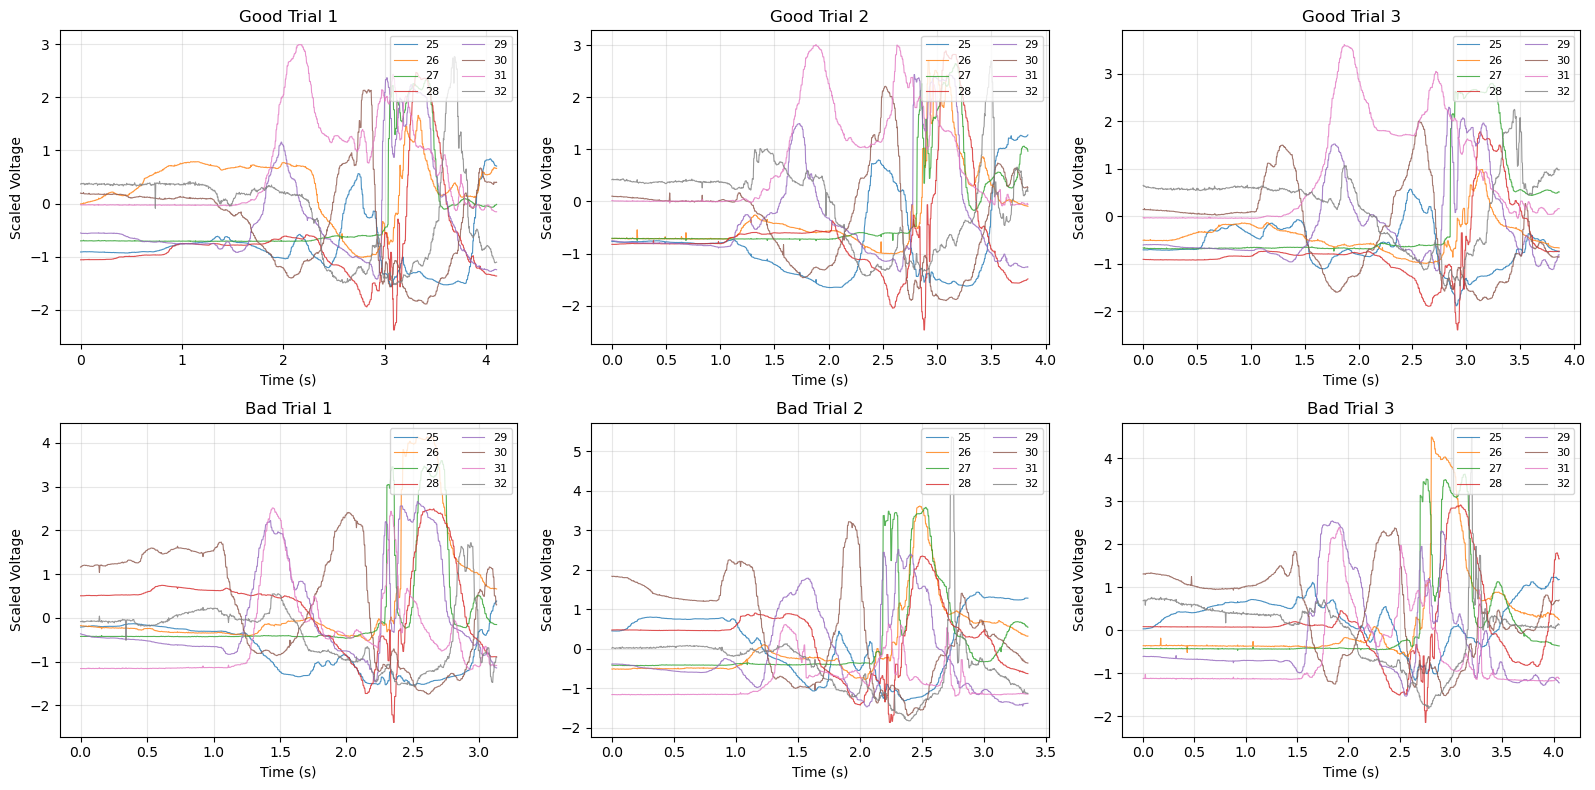

In [4]:
# Plot sample good vs bad trials
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i in range(3):
    plot_trial(pitch_good_ds[i], title=f"Good Trial {i+1}", ax=axes[0, i])
    plot_trial(pitch_bad_ds[i], title=f"Bad Trial {i+1}", ax=axes[1, i])
plt.tight_layout()
plt.show()

## 4. Dataset & DataLoader Setup

In [5]:
# Create 60/20/20 train/val/test split at the TRIAL level
# - Good data: split into train/val/test
# - Bad data: ALL goes to test (never seen during training)

splits = create_train_val_test_split(
    good_trials=pitch_good_ds,
    bad_trials=pitch_bad_ds,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=42
)

# Create windowed datasets
train_ds = WindowedTimeSeriesDataset(splits['train'], window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)
val_ds = WindowedTimeSeriesDataset(splits['val'], window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)
test_good_ds = WindowedTimeSeriesDataset(splits['test_good'], window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)
test_bad_ds = WindowedTimeSeriesDataset(splits['test_bad'], window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=window_collate, pin_memory=device.type == 'cuda')
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=window_collate, pin_memory=device.type == 'cuda')
test_good_loader = DataLoader(test_good_ds, batch_size=BATCH_SIZE, shuffle=False,
                              collate_fn=window_collate, pin_memory=device.type == 'cuda')
test_bad_loader = DataLoader(test_bad_ds, batch_size=BATCH_SIZE, shuffle=False,
                             collate_fn=window_collate, pin_memory=device.type == 'cuda')

print(f"\nDataset sizes:")
print(f"  Train: {len(train_ds)} windows")
print(f"  Val: {len(val_ds)} windows")
print(f"  Test (good): {len(test_good_ds)} windows")
print(f"  Test (bad): {len(test_bad_ds)} windows")

# Compute channel statistics from TRAINING data only
ch_mean, ch_std = fit_channel_stats_windows(train_loader)
ch_mean, ch_std = ch_mean.to(device), ch_std.to(device)
print(f"\nPer-channel mean (first 4): {ch_mean[:4].tolist()}")
print(f"Per-channel std (first 4): {ch_std[:4].tolist()}")

Split summary:
  Train:     12 good trials
  Val:       4 good trials
  Test good: 4 good trials
  Test bad:  11 bad trials
Created 318 windows from 12 trials
Created 114 windows from 4 trials
Created 99 windows from 4 trials
Created 261 windows from 11 trials

Dataset sizes:
  Train: 318 windows
  Val: 114 windows
  Test (good): 99 windows
  Test (bad): 261 windows

Per-channel mean (first 4): [-0.10010329633951187, -0.008948259055614471, -0.001574265887029469, 0.07698871195316315]
Per-channel std (first 4): [0.8779839873313904, 0.9811598658561707, 1.0085017681121826, 1.0342652797698975]


## 5. Model Architecture Comparison

In [6]:
# Compare model architectures
C = 8  # Number of channels
test_models = {
    'CAE1D (Baseline)': CAE1D(in_channels=C, latent_dim=64),
    'TCN-AE': TCNAE(in_channels=C, latent_dim=64),
    'UNet-AE': UNetAE(in_channels=C, latent_dim=64),
    'TCN-UNet': TCNUNet(in_channels=C, latent_dim=64),
}

model_info = {
    'CAE1D (Baseline)': ('~30 timesteps', 'Simple conv blocks'),
    'TCN-AE': ('~91 timesteps', 'Dilated convolutions'),
    'UNet-AE': ('~60 timesteps', 'Skip connections'),
    'TCN-UNet': ('~91 timesteps', 'Dilated + Skip'),
}

print(f"{'Model':<20} {'Parameters':>12} {'Receptive Field':>18} {'Key Feature':<25}")
print("-" * 75)
for name, m in test_models.items():
    params = count_parameters(m)
    rf, feature = model_info[name]
    print(f"{name:<20} {params:>12,} {rf:>18} {feature:<25}")

Model                  Parameters    Receptive Field Key Feature              
---------------------------------------------------------------------------
CAE1D (Baseline)          156,768      ~30 timesteps Simple conv blocks       
TCN-AE                    833,984      ~91 timesteps Dilated convolutions     
UNet-AE                   890,504      ~60 timesteps Skip connections         
TCN-UNet                1,023,208      ~91 timesteps Dilated + Skip           


## 6. Model Training

In [7]:
# Train all models
model_configs = [
    (CAE1D, 'CAE1D (Baseline)'),
    (TCNAE, 'TCN-AE'),
    (UNetAE, 'UNet-AE'),
    (TCNUNet, 'TCN-UNet'),
]

all_models, all_histories, all_results = train_all_models(
    model_configs, train_loader, val_loader,
    ch_mean, ch_std, device,
    epochs=EPOCHS, patience=PATIENCE
)

Starting model comparison training...
Training each model for up to 500 epochs with early stopping (patience=100)

Training: CAE1D (Baseline)
  Epoch 001 | train 1.1853 | val 1.3212 | patience 0/100
  Epoch 050 | train 0.8170 | val 1.0499 | patience 0/100
  Epoch 100 | train 0.5983 | val 0.8234 | patience 0/100
  Epoch 150 | train 0.5416 | val 0.7713 | patience 8/100
  Epoch 200 | train 0.4054 | val 0.6203 | patience 1/100
  Epoch 250 | train 0.3326 | val 0.5400 | patience 1/100
  Epoch 300 | train 0.2988 | val 0.4971 | patience 1/100
  Epoch 350 | train 0.2929 | val 0.4896 | patience 17/100
  Epoch 400 | train 0.2780 | val 0.4634 | patience 6/100
  Epoch 450 | train 0.2416 | val 0.4258 | patience 0/100
  Epoch 500 | train 0.2200 | val 0.4201 | patience 3/100
  Best val loss: 0.4112
  Training time: 28.9s

Training: TCN-AE
  Epoch 001 | train 1.0928 | val 1.2664 | patience 0/100
  Epoch 050 | train 0.4123 | val 0.5878 | patience 0/100
  Epoch 100 | train 0.2414 | val 0.4343 | patience 

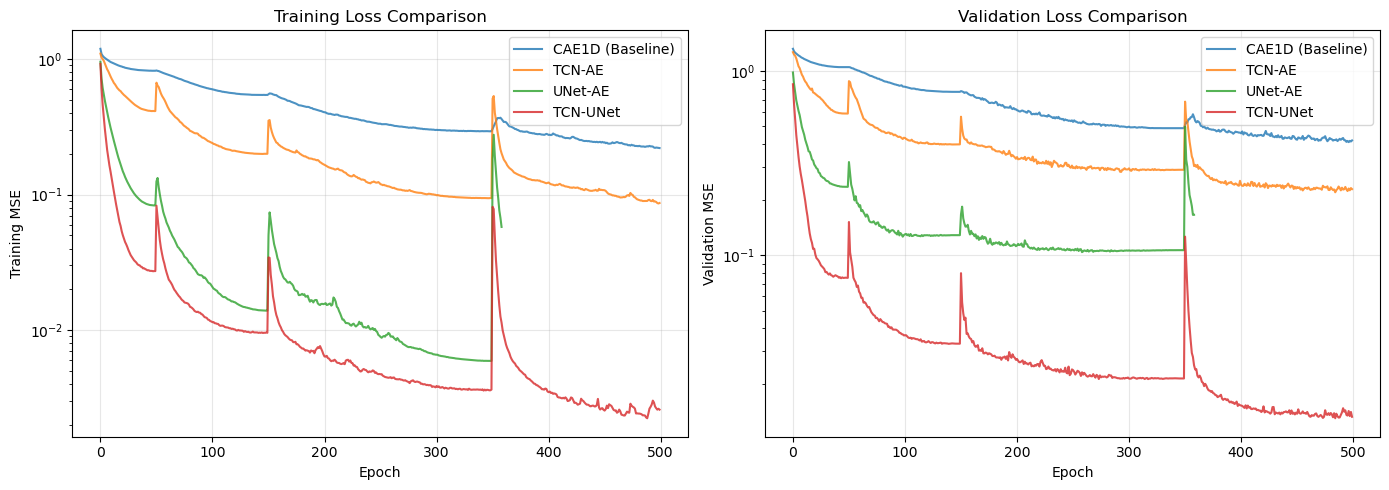


MODEL COMPARISON RESULTS

Model                  Best Val MSE  Improvement     Epochs   Time (s)
--------------------------------------------------------------------------------
CAE1D (Baseline)             0.4112     baseline        500       28.9
TCN-AE                       0.2196       +46.6%        500      110.2
UNet-AE                      0.1039       +74.7%        359       37.9
TCN-UNet                     0.0130       +96.8%        500       62.7

Best Model: TCN-UNet (Val MSE = 0.0130)


In [8]:
# Plot training curves
fig = plot_training_curves(all_histories, save_path='plots/model_comparison_training_curves.png')
plt.show()

# Results summary
print("\n" + "=" * 80)
print("MODEL COMPARISON RESULTS")
print("=" * 80)
print(f"\n{'Model':<20} {'Best Val MSE':>14} {'Improvement':>12} {'Epochs':>10} {'Time (s)':>10}")
print("-" * 80)

baseline_mse = all_results['CAE1D (Baseline)']['best_val_loss']
for name, res in all_results.items():
    improvement = (baseline_mse - res['best_val_loss']) / baseline_mse * 100
    imp_str = f"{improvement:+.1f}%" if name != 'CAE1D (Baseline)' else "baseline"
    print(f"{name:<20} {res['best_val_loss']:>14.4f} {imp_str:>12} {res['epochs_trained']:>10} {res['train_time']:>10.1f}")

best_model_name = min(all_results.keys(), key=lambda k: all_results[k]['best_val_loss'])
print(f"\nBest Model: {best_model_name} (Val MSE = {all_results[best_model_name]['best_val_loss']:.4f})")

In [9]:
# LOF Anomaly Detection using reconstruction error features


# Use the best model (TCN-UNet)
best_model = all_models['TCN-UNet']

# Fit LOF detector on training data (good pitches)
lof_detector = LOFAnomalyDetector(n_neighbors=5, contamination="auto")
lof_detector.fit(best_model, train_loader, ch_mean, ch_std, device)
print("LOF detector fitted on training data")

LOF detector fitted on training data


In [10]:
# Evaluate LOF on held-out TEST set (not training data!)
# - test_good: good trials that were NOT used for training/validation
# - test_bad: ALL bad trials (never seen during training)

results = lof_detector.evaluate(
    best_model, test_good_loader, test_bad_loader,
    ch_mean, ch_std, device
)

print("=" * 50)
print("LOF EVALUATION ON HELD-OUT TEST SET")
print("=" * 50)
print(f"Test good trials: {len(test_good_ds)} windows")
print(f"Test bad trials:  {len(test_bad_ds)} windows")
print()
print(f"Good test accuracy (correctly classified as normal): {100*results['good_accuracy']:.1f}%")
print(f"Bad detection rate (correctly detected as anomaly):  {100*results['bad_detection_rate']:.1f}%")

LOF EVALUATION ON HELD-OUT TEST SET
Test good trials: 99 windows
Test bad trials:  261 windows

Good test accuracy (correctly classified as normal): 19.2%
Bad detection rate (correctly detected as anomaly):  88.1%


Isolation Forest detector fitted on training data

ANOMALY DETECTION COMPARISON: LOF vs Isolation Forest

Method                      Good Accuracy   Bad Detection
------------------------------------------------------------
LOF                                 19.2%           88.1%
Isolation Forest                    20.2%           87.4%


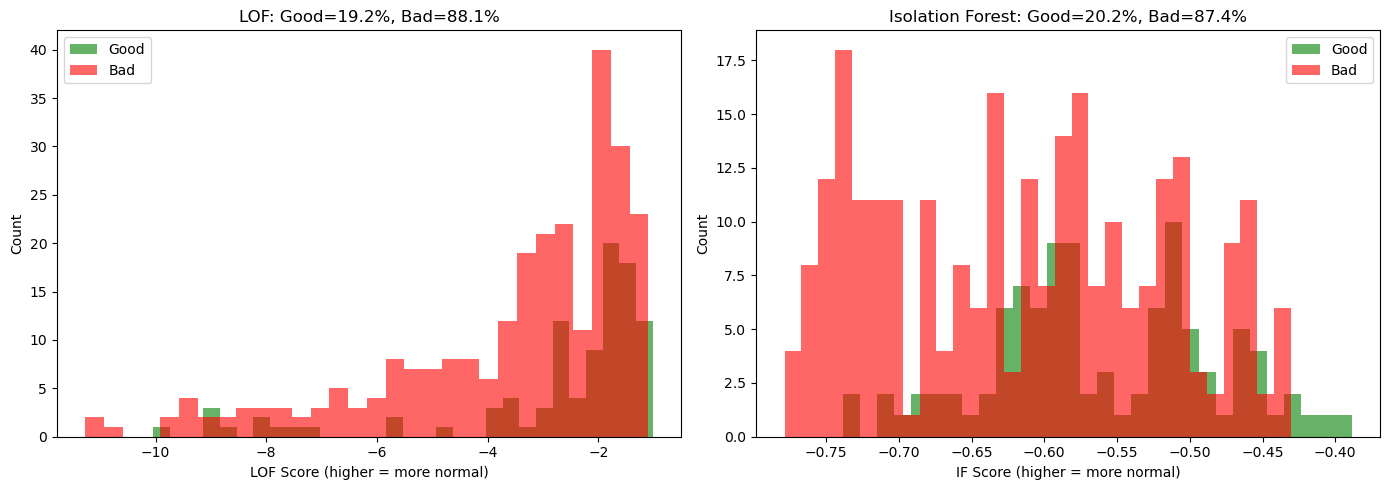

In [11]:
# Compare LOF vs Isolation Forest

# Fit Isolation Forest detector
iforest_detector = IsolationForestAnomalyDetector(n_estimators=100, contamination="auto")
iforest_detector.fit(best_model, train_loader, ch_mean, ch_std, device)
print("Isolation Forest detector fitted on training data")

# Evaluate both methods
lof_results = lof_detector.evaluate(best_model, test_good_loader, test_bad_loader, ch_mean, ch_std, device)
iforest_results = iforest_detector.evaluate(best_model, test_good_loader, test_bad_loader, ch_mean, ch_std, device)

print("\n" + "=" * 60)
print("ANOMALY DETECTION COMPARISON: LOF vs Isolation Forest")
print("=" * 60)
print(f"\n{'Method':<25} {'Good Accuracy':>15} {'Bad Detection':>15}")
print("-" * 60)
print(f"{'LOF':<25} {100*lof_results['good_accuracy']:>14.1f}% {100*lof_results['bad_detection_rate']:>14.1f}%")
print(f"{'Isolation Forest':<25} {100*iforest_results['good_accuracy']:>14.1f}% {100*iforest_results['bad_detection_rate']:>14.1f}%")

# Visualize score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LOF scores
axes[0].hist(lof_results['good_scores'], bins=30, alpha=0.6, label='Good', color='green')
axes[0].hist(lof_results['bad_scores'], bins=30, alpha=0.6, label='Bad', color='red')
axes[0].set_xlabel('LOF Score (higher = more normal)')
axes[0].set_ylabel('Count')
axes[0].set_title(f"LOF: Good={100*lof_results['good_accuracy']:.1f}%, Bad={100*lof_results['bad_detection_rate']:.1f}%")
axes[0].legend()

# Isolation Forest scores
axes[1].hist(iforest_results['good_scores'], bins=30, alpha=0.6, label='Good', color='green')
axes[1].hist(iforest_results['bad_scores'], bins=30, alpha=0.6, label='Bad', color='red')
axes[1].set_xlabel('IF Score (higher = more normal)')
axes[1].set_ylabel('Count')
axes[1].set_title(f"Isolation Forest: Good={100*iforest_results['good_accuracy']:.1f}%, Bad={100*iforest_results['bad_detection_rate']:.1f}%")
axes[1].legend()

plt.tight_layout()
plt.show()

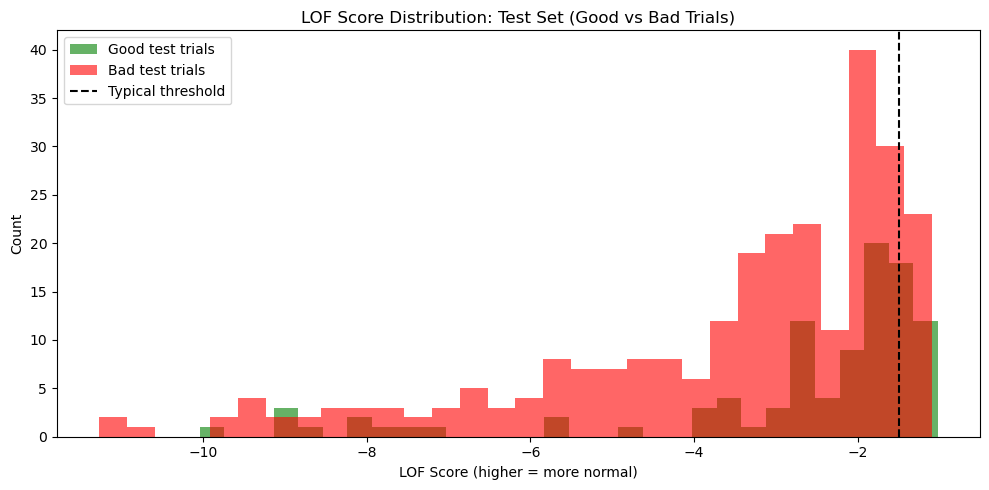

Good test scores - mean: -2.775, std: 2.099
Bad test scores - mean: -3.562, std: 2.246


In [12]:
# Visualize LOF score distributions on TEST set
good_scores = results['good_scores']
bad_scores = results['bad_scores']

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(good_scores, bins=30, alpha=0.6, label='Good test trials', color='green')
ax.hist(bad_scores, bins=30, alpha=0.6, label='Bad test trials', color='red')
ax.axvline(x=-1.5, color='black', linestyle='--', label='Typical threshold')
ax.set_xlabel('LOF Score (higher = more normal)')
ax.set_ylabel('Count')
ax.set_title('LOF Score Distribution: Test Set (Good vs Bad Trials)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Good test scores - mean: {good_scores.mean():.3f}, std: {good_scores.std():.3f}")
print(f"Bad test scores - mean: {bad_scores.mean():.3f}, std: {bad_scores.std():.3f}")

In [13]:
# Extract scaled features for visualization (using TEST set)
def get_features_for_viz(detector, model, loader, ch_mean, ch_std, device):
    """Extract scaled features for visualization."""
    X = detector._extract_features(model, loader, ch_mean, ch_std, device)
    return detector.scaler.transform(X)

X_good = get_features_for_viz(lof_detector, best_model, test_good_loader, ch_mean, ch_std, device)
X_bad = get_features_for_viz(lof_detector, best_model, test_bad_loader, ch_mean, ch_std, device)
X_all = np.vstack([X_good, X_bad])

print(f"Feature matrix shapes: Good test={X_good.shape}, Bad test={X_bad.shape}, All={X_all.shape}")

Feature matrix shapes: Good test=(99, 24), Bad test=(261, 24), All=(360, 24)


In [14]:
# PCA Visualization
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_all)
labels = np.array(["Good"] * len(X_good) + ["Bad"] * len(X_bad))

# 3) Interactive 3D scatter
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=labels,
    opacity=0.6,
    title=(
        "PCA: LOF Feature Space (24D → 3D)<br>"
        f"Var: PC1={pca.explained_variance_ratio_[0]:.1%}, "
        f"PC2={pca.explained_variance_ratio_[1]:.1%}, "
        f"PC3={pca.explained_variance_ratio_[2]:.1%}"
    ),
    labels={"x": "PC1", "y": "PC2", "z": "PC3"},
)

fig.update_traces(marker=dict(size=4))
fig.show()

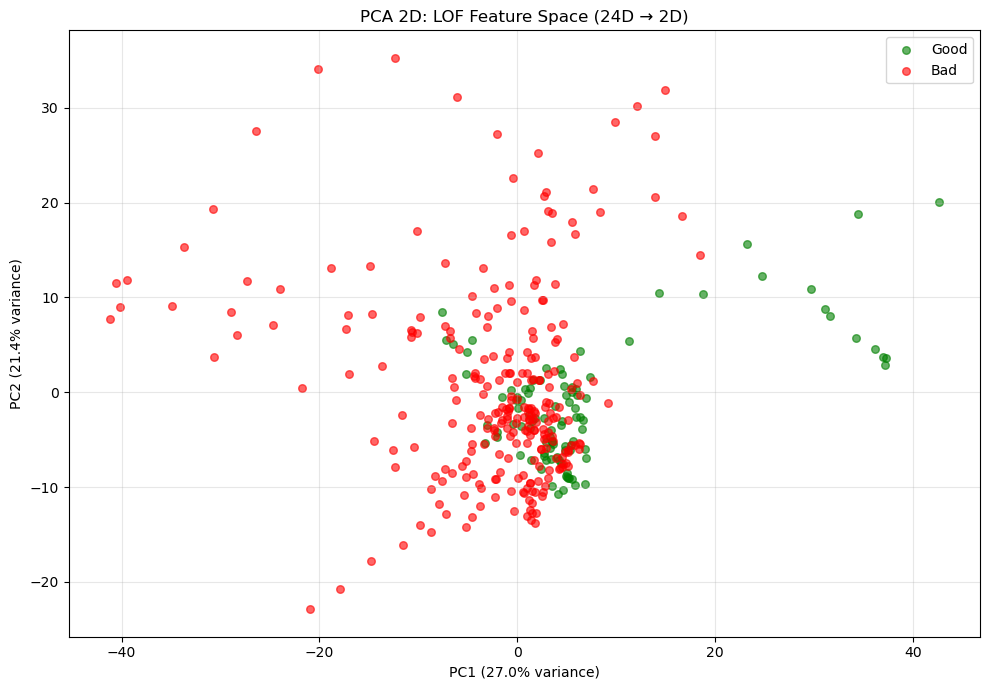

In [15]:
# PCA 2D Visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_all)

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(X_pca_2d[:len(X_good), 0], X_pca_2d[:len(X_good), 1], 
           c='green', alpha=0.6, label='Good', s=30)
ax.scatter(X_pca_2d[len(X_good):, 0], X_pca_2d[len(X_good):, 1], 
           c='red', alpha=0.6, label='Bad', s=30)
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA 2D: LOF Feature Space (24D → 2D)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# t-SNE 3D Interactive Visualization
from sklearn.manifold import TSNE
import plotly.graph_objects as go

tsne = TSNE(n_components=3, perplexity=30, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_all)

fig = go.Figure()

# Good trials
fig.add_trace(go.Scatter3d(
    x=X_tsne[:len(X_good), 0],
    y=X_tsne[:len(X_good), 1],
    z=X_tsne[:len(X_good), 2],
    mode='markers',
    marker=dict(size=5, color='green', opacity=0.6),
    name='Good'
))

# Bad trials
fig.add_trace(go.Scatter3d(
    x=X_tsne[len(X_good):, 0],
    y=X_tsne[len(X_good):, 1],
    z=X_tsne[len(X_good):, 2],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.6),
    name='Bad'
))

fig.update_layout(
    title='t-SNE 3D: LOF Feature Space',
    scene=dict(xaxis_title='t-SNE 1', yaxis_title='t-SNE 2', zaxis_title='t-SNE 3'),
    width=900, height=700
)
fig.show()

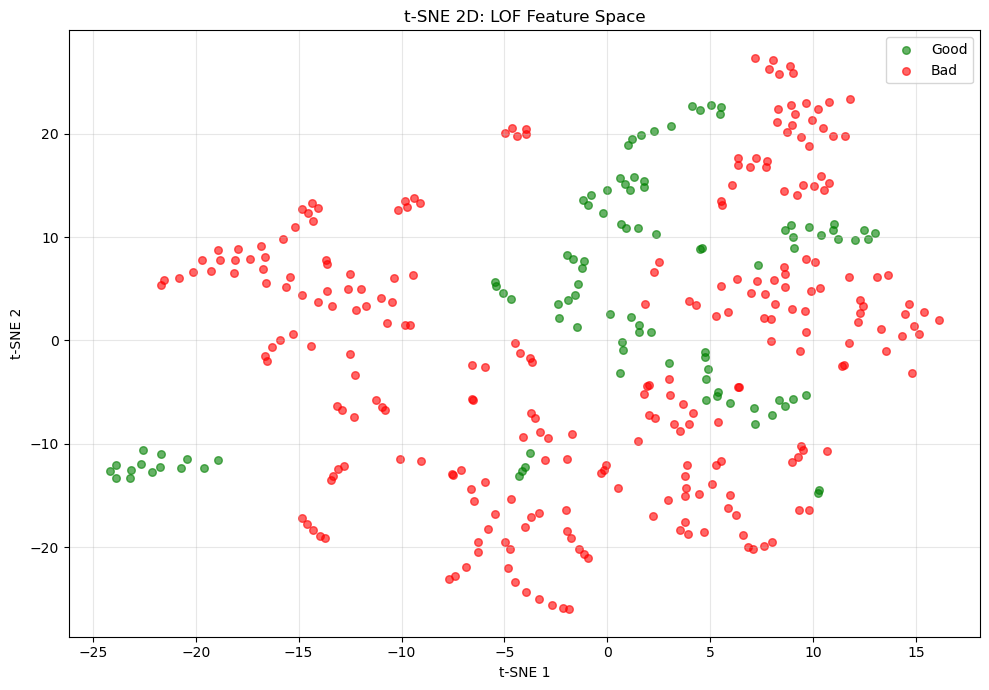

In [17]:
# t-SNE 2D Visualization
tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne_2d = tsne_2d.fit_transform(X_all)

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(X_tsne_2d[:len(X_good), 0], X_tsne_2d[:len(X_good), 1], 
           c='green', alpha=0.6, label='Good', s=30)
ax.scatter(X_tsne_2d[len(X_good):, 0], X_tsne_2d[len(X_good):, 1], 
           c='red', alpha=0.6, label='Bad', s=30)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE 2D: LOF Feature Space')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# UMAP 3D Interactive Visualization (requires: pip install umap-learn)
try:
    import umap
    import plotly.graph_objects as go
    
    reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = reducer.fit_transform(X_all)
    
    fig = go.Figure()
    
    # Good trials
    fig.add_trace(go.Scatter3d(
        x=X_umap[:len(X_good), 0],
        y=X_umap[:len(X_good), 1],
        z=X_umap[:len(X_good), 2],
        mode='markers',
        marker=dict(size=5, color='green', opacity=0.6),
        name='Good'
    ))
    
    # Bad trials
    fig.add_trace(go.Scatter3d(
        x=X_umap[len(X_good):, 0],
        y=X_umap[len(X_good):, 1],
        z=X_umap[len(X_good):, 2],
        mode='markers',
        marker=dict(size=5, color='red', opacity=0.6),
        name='Bad'
    ))
    
    fig.update_layout(
        title='UMAP 3D: LOF Feature Space',
        scene=dict(xaxis_title='UMAP 1', yaxis_title='UMAP 2', zaxis_title='UMAP 3'),
        width=900, height=700
    )
    fig.show()
    
except ImportError:
    print("UMAP not installed. Run: pip install umap-learn")

c:\Users\TonyZheng\miniconda3\envs\baseball\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



c:\Users\TonyZheng\miniconda3\envs\baseball\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



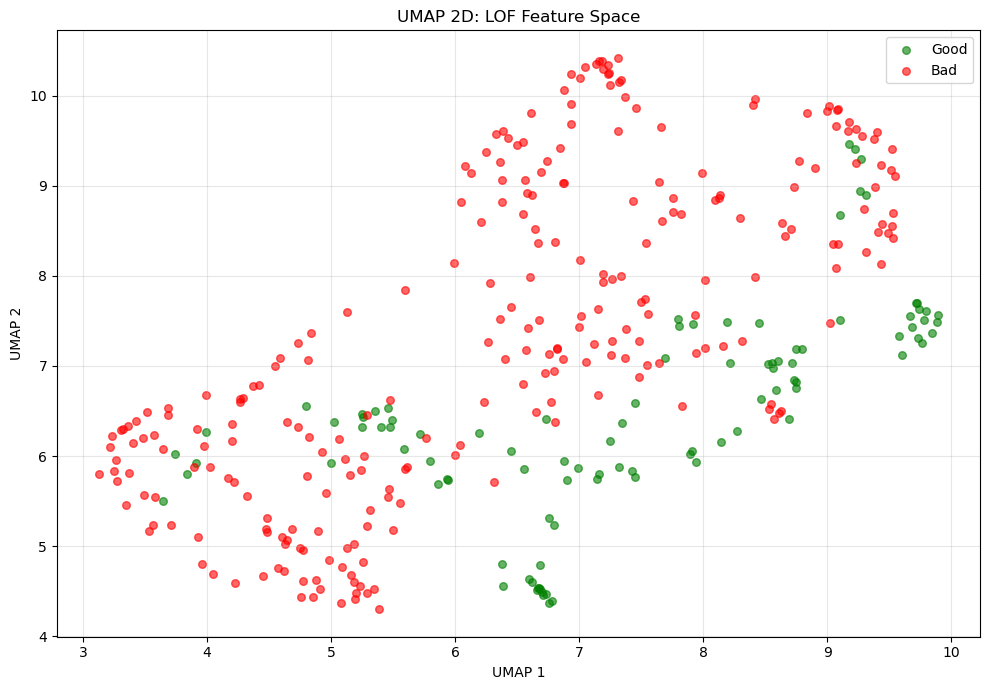

In [19]:
# UMAP 2D Visualization
try:
    reducer_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap_2d = reducer_2d.fit_transform(X_all)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(X_umap_2d[:len(X_good), 0], X_umap_2d[:len(X_good), 1], 
               c='green', alpha=0.6, label='Good', s=30)
    ax.scatter(X_umap_2d[len(X_good):, 0], X_umap_2d[len(X_good):, 1], 
               c='red', alpha=0.6, label='Bad', s=30)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('UMAP 2D: LOF Feature Space')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except NameError:
    print("UMAP not imported. Run the UMAP 3D cell first or install: pip install umap-learn")

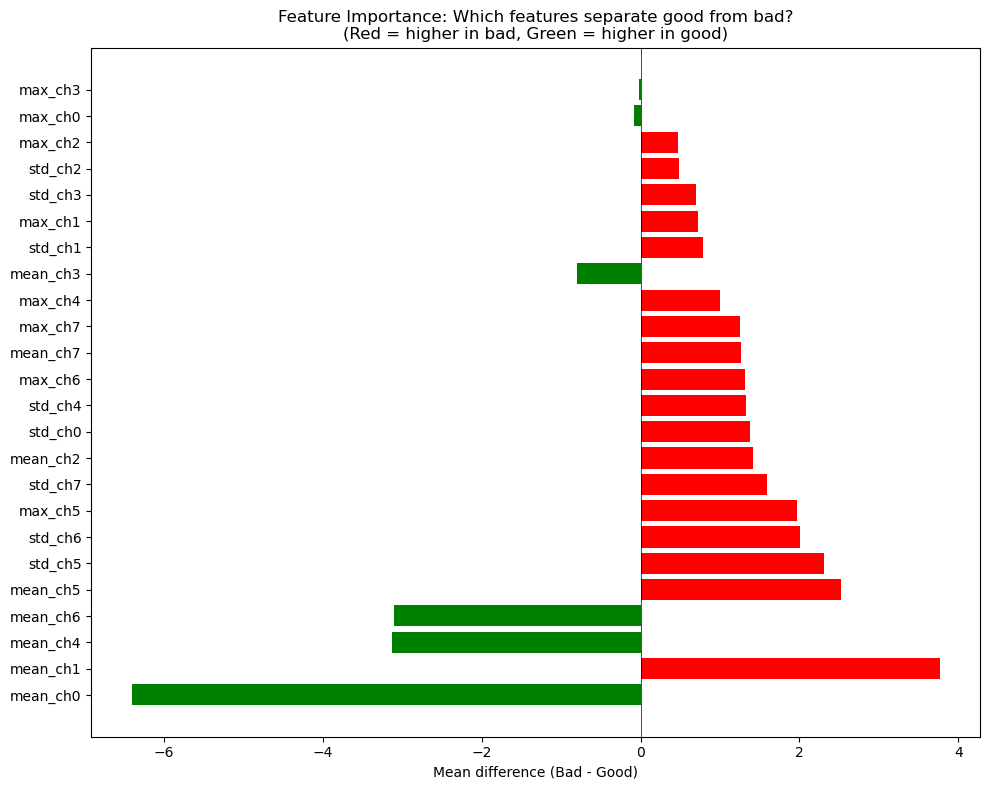

Top 5 discriminative features:
  mean_ch0: diff = -6.406
  mean_ch1: diff = 3.764
  mean_ch4: diff = -3.128
  mean_ch6: diff = -3.101
  mean_ch5: diff = 2.517


In [20]:
# Feature Importance: Which features separate good from bad?
feature_names = [f'mean_ch{i}' for i in range(8)] + \
                [f'std_ch{i}' for i in range(8)] + \
                [f'max_ch{i}' for i in range(8)]

# Mean difference between bad and good
diff = X_bad.mean(axis=0) - X_good.mean(axis=0)

# Sort by absolute difference
sorted_idx = np.argsort(np.abs(diff))[::-1]

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['red' if d > 0 else 'green' for d in diff[sorted_idx]]
ax.barh([feature_names[i] for i in sorted_idx], diff[sorted_idx], color=colors)
ax.set_xlabel('Mean difference (Bad - Good)')
ax.set_title('Feature Importance: Which features separate good from bad?\n(Red = higher in bad, Green = higher in good)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# Top 5 most important features
print("Top 5 discriminative features:")
for i in sorted_idx[:5]:
    print(f"  {feature_names[i]}: diff = {diff[i]:.3f}")

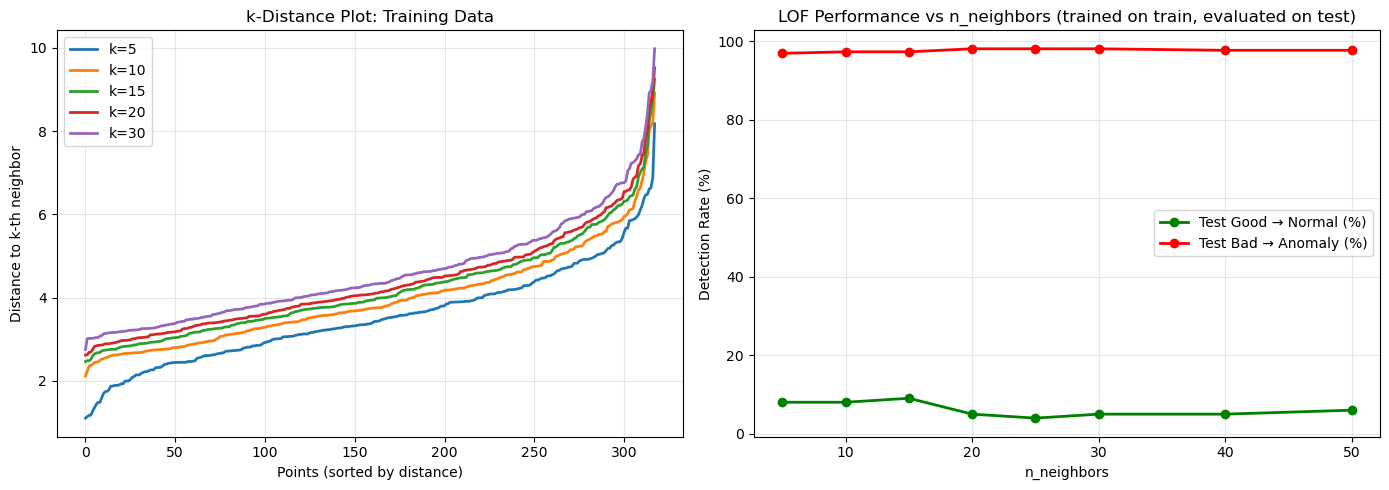


Recommended n_neighbors: 20
  Good test trials correctly classified: 5.1%
  Bad test trials detected as anomaly: 98.1%


In [21]:
# k-Distance Plot and LOF hyperparameter tuning
# Use TRAINING features to fit LOF, TEST features to evaluate

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor

# Get training features for fitting LOF
X_train = lof_detector._extract_features(best_model, train_loader, ch_mean, ch_std, device)
X_train_scaled = lof_detector.scaler.transform(X_train)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: k-distance curves for different k values (on training data)
k_values = [5, 10, 15, 20, 30]
for k in k_values:
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X_train_scaled)
    distances, _ = nn.kneighbors(X_train_scaled)
    k_distances = np.sort(distances[:, -1])
    axes[0].plot(k_distances, label=f'k={k}', linewidth=2)

axes[0].set_ylabel('Distance to k-th neighbor')
axes[0].set_xlabel('Points (sorted by distance)')
axes[0].set_title('k-Distance Plot: Training Data')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Detection rate vs n_neighbors (fit on train, evaluate on test)
n_neighbors_range = [5, 10, 15, 20, 25, 30, 40, 50]
good_rates = []
bad_rates = []

for n in n_neighbors_range:
    lof_test = LocalOutlierFactor(n_neighbors=n, contamination=0.1, novelty=True)
    lof_test.fit(X_train_scaled)  # Fit on training data
    
    good_pred = lof_test.predict(X_good)  # Evaluate on test good
    bad_pred = lof_test.predict(X_bad)    # Evaluate on test bad
    
    good_rates.append((good_pred == 1).mean() * 100)  # % classified as normal
    bad_rates.append((bad_pred == -1).mean() * 100)   # % classified as anomaly

axes[1].plot(n_neighbors_range, good_rates, 'g-o', label='Test Good → Normal (%)', linewidth=2)
axes[1].plot(n_neighbors_range, bad_rates, 'r-o', label='Test Bad → Anomaly (%)', linewidth=2)
axes[1].set_xlabel('n_neighbors')
axes[1].set_ylabel('Detection Rate (%)')
axes[1].set_title('LOF Performance vs n_neighbors (trained on train, evaluated on test)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best n_neighbors (maximize bad detection while keeping good detection high)
best_idx = np.argmax([b for g, b in zip(good_rates, bad_rates) if g > 70] or bad_rates)
print(f"\nRecommended n_neighbors: {n_neighbors_range[best_idx]}")
print(f"  Good test trials correctly classified: {good_rates[best_idx]:.1f}%")
print(f"  Bad test trials detected as anomaly: {bad_rates[best_idx]:.1f}%")